In [61]:
# Imports
import torch
import torch.nn.functional as F
cuda = torch.cuda.is_available()
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")

In [62]:
USE_CUDA = True
device = 'cuda:0' if torch.cuda.is_available() and USE_CUDA else 'cpu'

# Ladder Deep Generative Model

The final model we present is the ladder deep generative model which combines the idea of the ladder variational auto encoder with the deep generative model. It therefore learns a hierarchical relationship of latent variables and therefore has many of the properties of standard ladder VAEs such as strong generative performance and good disentanglement. The model below shows a three layer LadderDGM, but the number of stochastic layer can be arbitrary.

<img src="../images/ladderdgm.png" width="400px"/>

This model serves as an example of what you can do with the tools provided this library to create new and novel models.

In [91]:
from models import LadderDeepGenerativeModel

y_dim = 10
z_dim = [128, 64, 32]
h_dim = [256, 128, 64]

model = LadderDeepGenerativeModel([784, y_dim, z_dim, h_dim]).to(device)
model

LadderDeepGenerativeModel(
  (encoder): ModuleList(
    (0): LadderEncoder(
      (linear): Linear(in_features=784, out_features=256, bias=True)
      (batchnorm): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sample): GaussianSample(
        (mu): Linear(in_features=256, out_features=128, bias=True)
        (log_var): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (1): LadderEncoder(
      (linear): Linear(in_features=256, out_features=128, bias=True)
      (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sample): GaussianSample(
        (mu): Linear(in_features=128, out_features=64, bias=True)
        (log_var): Linear(in_features=128, out_features=64, bias=True)
      )
    )
    (2): LadderEncoder(
      (linear): Linear(in_features=138, out_features=64, bias=True)
      (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

## Training

We train the model similarly to the Ladder VAE, but add label information to the lower bound. The final bound is similar to that presented in the "Deep Generative Model" notebook. From a programming point of view, the model is trained in exactly the same way as the `DeepGenerativeModel` and the `AuxiliaryDeepGenerativeModel`.

This simultanously highlights the power of the library, as it is model agnostic as long as the given model subclasses the `VariationalAutoencoder` class.

In [92]:
from datautils import get_mnist

# Only use 10 labelled examples per class
# The rest of the data is unlabelled.
labelled, unlabelled, validation = get_mnist(location="./", batch_size=64, labels_per_class=10)
alpha = 0.1 * (len(unlabelled) + len(labelled)) / len(labelled)

def binary_cross_entropy(r, x):
#     return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)
    return F.binary_cross_entropy(r, x, reduction='none').sum(dim=1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [93]:
from itertools import cycle
from inference import SVI, DeterministicWarmup

# We will need to use warm-up in order to achieve good performance.
# Over 200 calls to SVI we change the autoencoder from
# deterministic to stochastic.
beta = DeterministicWarmup(n=200)

elbo = SVI(model, likelihood=binary_cross_entropy, beta=beta)

The library is conventially packed with the `SVI` method that does all of the work of calculating the lower bound for both labelled and unlabelled data depending on whether the label is given. It also manages to perform the enumeration of all the labels.

Remember that the labels have to be in a *one-hot encoded* format in order to work with SVI.

In [94]:
for epoch in range(10):
    model.train()
    total_loss, accuracy = (0, 0)
    for (x, y), (u, _) in zip(cycle(labelled), unlabelled):
        # Wrap in variables
        x, y, u = Variable(x).to(device), Variable(y).to(device), Variable(u).to(device)
            
        L = -elbo(x, y)
        U = -elbo(u)

        # Add auxiliary classification loss q(y|x)
        logits = model.classify(x)
        
        # Regular cross entropy
        classification_loss = torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()
#         classification_loss = - F.cross_entropy(logits, y.max(dim=1)[1])

        J_alpha = L - alpha * classification_loss + U

        J_alpha.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += J_alpha.data.item()
        accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())
    
    if epoch % 1 == 0:
        model.eval()
        m = len(unlabelled)
        print("Epoch: {}".format(epoch))
        print("[Train]\t\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

        total_loss, accuracy = (0, 0)
        for x, y in validation:
            x, y = Variable(x).to(device), Variable(y).to(device)

            L = -elbo(x, y)
            U = -elbo(x)

            logits = model.classify(x)
            classification_loss = -torch.sum(y * torch.log(logits + 1e-8), dim=1).mean()

            J_alpha = L + alpha * classification_loss + U

            total_loss += J_alpha.data.item()

            _, pred_idx = torch.max(logits, 1)
            _, lab_idx = torch.max(y, 1)
            accuracy += torch.mean((torch.max(logits, 1)[1].data == torch.max(y, 1)[1].data).float())

        m = len(validation)
        print("[Validation]\t J_a: {:.2f}, accuracy: {:.2f}".format(total_loss / m, accuracy / m))

Epoch: 0
[Train]		 J_a: 447.45, accuracy: 0.99
[Validation]	 J_a: 435.27, accuracy: 0.68
Epoch: 1
[Train]		 J_a: 353.44, accuracy: 1.00
[Validation]	 J_a: 423.54, accuracy: 0.70
Epoch: 2
[Train]		 J_a: 324.78, accuracy: 1.00
[Validation]	 J_a: 413.80, accuracy: 0.75
Epoch: 3
[Train]		 J_a: 310.11, accuracy: 1.00
[Validation]	 J_a: 405.58, accuracy: 0.78
Epoch: 4
[Train]		 J_a: 305.05, accuracy: 1.00
[Validation]	 J_a: 412.72, accuracy: 0.78
Epoch: 5
[Train]		 J_a: 298.83, accuracy: 1.00
[Validation]	 J_a: 416.36, accuracy: 0.77
Epoch: 6
[Train]		 J_a: 296.17, accuracy: 1.00
[Validation]	 J_a: 410.73, accuracy: 0.79
Epoch: 7
[Train]		 J_a: 292.03, accuracy: 1.00
[Validation]	 J_a: 404.89, accuracy: 0.80
Epoch: 8
[Train]		 J_a: 285.64, accuracy: 1.00
[Validation]	 J_a: 407.73, accuracy: 0.80
Epoch: 9
[Train]		 J_a: 282.68, accuracy: 1.00
[Validation]	 J_a: 405.40, accuracy: 0.81


## Conditional generation

When the model is done training you can generate samples conditionally given some normal distributed noise $z$ and a label $y$.

*The model below has only trained for 10 iterations, so the perfomance is not representative*.

In [97]:
from utils import onehot
model.eval()

z = Variable(torch.randn(16, 32)).to(device)

# Generate a batch of 5s
y = Variable(onehot(10)(5).repeat(16, 1)).to(device)

x_mu = model.sample(z, y)

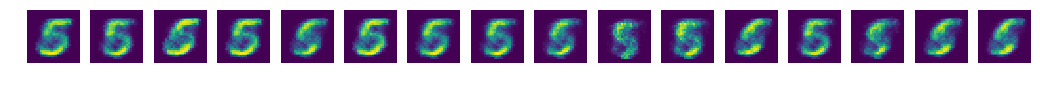

In [99]:
f, axarr = plt.subplots(1, 16, figsize=(18, 12))

samples = x_mu.data.view(-1, 28, 28).cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i])
    ax.axis("off")